# Setup

In [1]:
from idrtools import math
from twins_embedding import TwinsEmbeddingAnalysis
from matplotlib import pyplot as plt
from matplotlib import colors
from tqdm.notebook import tqdm
from astropy.table import Table
import utils
import numpy as np

/home/kyle/supernova/snfactory/manifold_twins/analysis/twins_embedding.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

In [3]:
a = TwinsEmbeddingAnalysis()
a.settings['figure_directory'] = './output_generation/figures/'
a.settings['latex_directory'] = './output_generation/latex/'
a.run_analysis()

Loading dataset...
    IDR:          BLACKSTON
    Phase range: [-5.0, 5.0] days
    Bin velocity: 1000.0


  0%|          | 0/415 [00:00<?, ?it/s]

Estimating the spectra at maximum light...
    Loaded cached stan model
    Using saved stan result
Reading between the lines...
    Loaded cached stan model
    Using saved stan result
Building masks...
    Masking 30/203 targets whose uncertainty power is 
    more than 0.100 of the intrinsic power.
Generating the manifold learning embedding...
Loading other indicators of diversity...
Fitting RBTL Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.073 ± 0.008
    gp_kernel_amplitude       0.164 ± 0.082
    gp_length_scale           5.541 ± 3.315
    offset                    -0.116 ± 0.124
    covariate_slope_0         -0.122 ± 0.051
    Fit NMAD                  0.083 mag
    Fit std                   0.101 mag
Fitting SALT2 Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    intrinsic_dispersion      0.085

# Estimating the spectra at maximum light

## Examples of maximum light models

In [4]:
phase_cmap = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=-5, vmax=5),
    cmap=colors.LinearSegmentedColormap.from_list('phase_cmap', plt.cm.plasma(np.linspace(0., 0.9, 100)))
)

def get_time_evolution_data(idx):
    fluxes = a.flux[a.target_map == idx]
    phases = a.salt_phases[a.target_map == idx]
    model = a.differential_evolution_result['maximum_flux'][idx]
    model_err = a.differential_evolution_result['maximum_fluxerr'][idx]
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]
    
    return fluxes, phases, model, model_err, gray_offsets, model_diffs

def plot_time_evolution_model(idx, ax=None, skip_same_night=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    last_phase = None
    for flux, phase in zip(fluxes, phases):
        if skip_same_night and last_phase is not None and phase - last_phase < 0.5:
            # Same night, skip it
            continue
        last_phase = phase
        a.plot_flux(ax, flux, label='Data ($%.2f$ days)' % phase, c=phase_cmap.to_rgba(phase))
    a.plot_flux(ax, model, model_err, c='k', ls='--', label='Model (0 days)', uncertainty_label='Model Uncertainty')
    ax.legend()
    ax.set_title(a.targets[idx])
    
def plot_time_evolution_difference(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    phase_slope = a.differential_evolution_result['phase_slope']
    phase_quadratic = a.differential_evolution_result['phase_quadratic']
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]

    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model), label='Data ($%.2f$ days)' % phase, c=phase_cmap.to_rgba(phase))
    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, model_diff, label='Model ($%.2f$ days)' % phase, c=phase_cmap.to_rgba(phase), ls='--')
    ax.legend(ncol=2, loc=1)
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference from\nmaximum light (mag)')

def plot_time_evolution_residuals(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)
    
    # Plot the interpolation residuals
    for i, (flux, phase, model_diff) in enumerate(zip(fluxes, phases, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model) - model_diff, label='Residuals ($%.2f$ days)' % phase,
                c=phase_cmap.to_rgba(phase))
    ax.legend()
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Interpolation residuals (mag)')
    
def plot_same_night(idx):
    plot_time_evolution_model(idx)
    plot_time_evolution_difference(idx)
    plot_time_evolution_residuals(idx)

from ipywidgets import interact
interact(plot_same_night, idx=(0, len(a.targets)-1))

interactive(children=(IntSlider(value=101, description='idx', max=202), Output()), _dom_classes=('widget-inter…

<function __main__.plot_same_night(idx)>

In [5]:
# Out of sample reconstruction test
def plot_oos_reconstruction(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    phase_slope = a.differential_evolution_result['phase_slope']
    phase_quadratic = a.differential_evolution_result['phase_quadratic']
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]

    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model), label='Data ($%.2f$ days)' % phase, c='C%d' % i)
    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, model_diff, label='Model ($%.2f$ days)' % phase, c='C%d' % i, ls='--')
    ax.legend(ncol=2, loc=1)
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference from\nmaximum light (mag)')

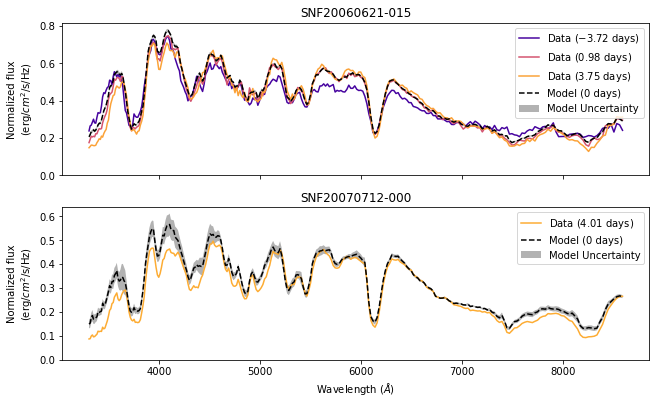

In [6]:
# plot_targets = ['PTF13ayw', 'SN2004gc']
plot_targets = ['SNF20060621-015', 'SNF20070712-000']

figsize = a.settings['spectrum_plot_figsize_double']
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

for ax, plot_target in zip(axes, plot_targets):
    target_names = np.array([i.name for i in a.targets])
    plot_idx = np.where(target_names == plot_target)[0][0]

    plot_time_evolution_model(plot_idx, ax, skip_same_night=True)

for ax in axes[:-1]:
    ax.set_xlabel(None)

a.savefig('time_evolution_model.pdf', fig)

## Differential time evolution model

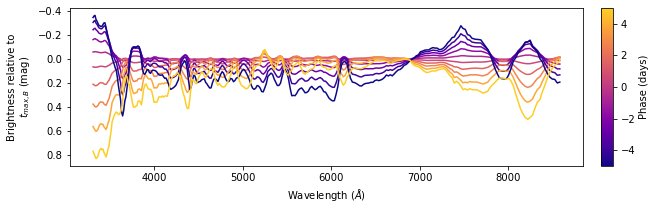

In [7]:
phase_slope = a.differential_evolution_result['phase_slope']
phase_quadratic = a.differential_evolution_result['phase_quadratic']
phase_slope_x1 = a.differential_evolution_result['phase_slope_x1']
phase_quadratic_x1 = a.differential_evolution_result['phase_quadratic_x1']

def evaluate_phase_difference(phase, x1=0):
    phase_difference = (
        phase_slope * phase
        + phase_quadratic * phase * phase
        + phase_slope_x1 * x1 * phase
        + phase_quadratic_x1 * x1 * phase * phase
    )
    
    return phase_difference

# Look at change in phase for the same x1
max_phase = a.settings['phase_range']
min_phase = -a.settings['phase_range']
num_phases = 10
phases = np.linspace(min_phase, max_phase, num_phases)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])

for phase in phases:
    ax.plot(a.wave, evaluate_phase_difference(phase), c=phase_cmap.to_rgba(phase), zorder=np.abs(phase))

fig.colorbar(phase_cmap, ax=ax, orientation='vertical', label='Phase (days)', aspect=40)

ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax.set_ylabel('Brightness relative to\n$t_{max,B}$ (mag)')
ax.invert_yaxis()

a.savefig('time_evolution_phase_difference.pdf', fig)

In [8]:
# SALT2 x1 difference plots. This only makes sense if we are including x1 in the
# differential evolution model, so these are blank with the default settings.
# I only make them if x1 was actually used.

def plot_x1_difference(phase):
    # Look at change in phase for the same x1
    min_x1 = -2
    max_x1 = 2
    num_x1s = 10
    x1s = np.linspace(min_x1, max_x1, num_x1s)

    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    norm = plt.Normalize(vmin=min_x1, vmax=max_x1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(x1s)

    for x1 in x1s:
        diff = evaluate_phase_difference(phase, x1) - evaluate_phase_difference(phase, 0)
        ax.plot(a.wave, diff, c=cmap(norm(x1)))

    fig.colorbar(sm, label='SALT2 $x_1$')

    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference relative to $x_1=0$ (mag)')
    ax.set_title('Difference in interpolation at %+d days' % phase)
    ax.set_ylim(0.4, -0.4)
    a.savefig('time_evolution_x1_difference_phase_%d.pdf' % phase, fig)

if a.settings['differential_evolution_use_salt_x1']:
    for phase in [-5, -3, -1, 1, 3, 5]:
        plot_x1_difference(phase)

## Gray dispersion

Gray dispersion scale: 0.0296 mag


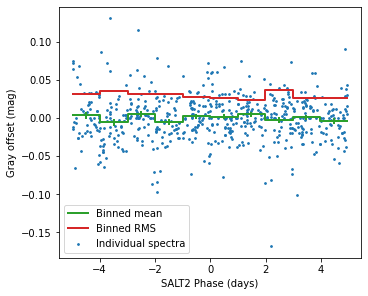

In [9]:
# Check if the gray dispersion is phase dependent. This should not be the
# case if the model is working properly.
gray_scale = a.differential_evolution_result['gray_dispersion_scale']
print(f"Gray dispersion scale: {gray_scale:.4f} mag")

plt.figure()
gray_offsets = a.differential_evolution_result['gray_offsets']
plt.scatter(a.salt_phases, gray_offsets, s=3, label='Individual spectra')
math.plot_binned_mean(a.salt_phases, gray_offsets, c='C2', lw=2, label='Binned mean')
math.plot_binned_rms(a.salt_phases, gray_offsets, c='C3', lw=2, label='Binned RMS')
plt.xlabel('SALT2 Phase (days)')
plt.ylabel('Gray offset (mag)')
plt.legend()
a.savefig('gray_offset_vs_phase.pdf')

(-0.1, 0.1)

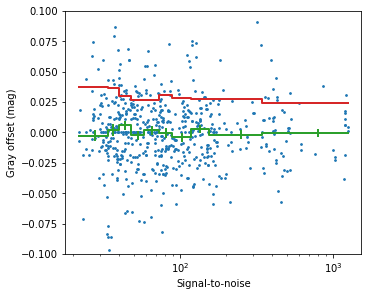

In [10]:
plt.figure()
s2n = np.array([np.median(i.flux / i.fluxerr) for i in a.spectra])
plt.scatter(s2n, gray_offsets, s=3, label='Individual spectra')
math.plot_binned_mean(s2n, gray_offsets, equal_bin_counts=True, c='C2', lw=2, label='Binned mean')
math.plot_binned_rms(s2n, gray_offsets, equal_bin_counts=True, c='C3', lw=2, label='Binned RMS')
plt.xlabel('Signal-to-noise')
plt.ylabel('Gray offset (mag)')
plt.xscale('log')
plt.ylim(-0.1, 0.1)

## Differential evolution uncertainty

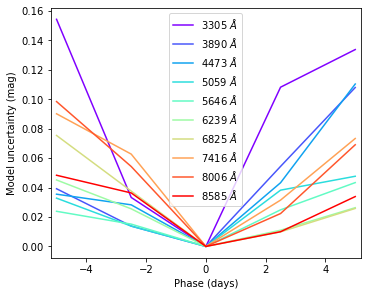

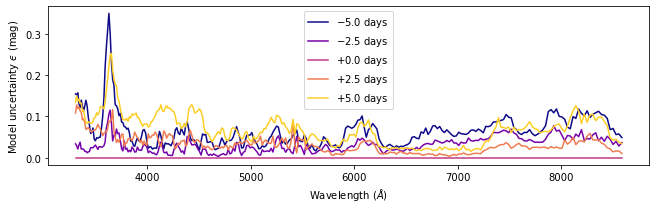

In [11]:
coefs = a.differential_evolution_result['phase_dispersion_coefficients']
num_phase_coefficients = len(coefs)

phase_range = a.settings['phase_range']

def evaluate_phase_dispersion(phase):
    phase_scale = np.abs((num_phase_coefficients / 2) * (phase / phase_range))
    full_bins = int(np.floor(phase_scale))
    remainder = phase_scale - full_bins

    phase_coefficients = np.zeros(num_phase_coefficients)

    for j in range(full_bins + 1):
        if j == full_bins:
            weight = remainder
        else:
            weight = 1

        if weight == 0:
            break

        if phase > 0:
            phase_bin = num_phase_coefficients // 2 + j
        else:
            phase_bin = num_phase_coefficients // 2 - 1 - j
            
        phase_coefficients[phase_bin] = weight
        
    fractional_dispersion = phase_coefficients.dot(coefs)
    
    # Convert to magnitudes
    mag_dispersion = utils.frac_to_mag(fractional_dispersion)

    return mag_dispersion

phases = np.linspace(-phase_range, phase_range, 1 + num_phase_coefficients)

eval_coefs = np.array([evaluate_phase_dispersion(phase) for phase in phases])

# Uncertainties for different wavelengths
plt.figure()
num_wave = 10
for i in range(num_wave):
    min_wave = a.wave[0]
    max_wave = a.wave[-1]
    wave_range = max_wave - min_wave
    target_wave = min_wave + wave_range * i / (num_wave - 1)
    idx = np.argmin(np.abs(a.wave - target_wave))
    use_wave = a.wave[idx]
    color = plt.cm.rainbow((use_wave - min_wave) / wave_range)
    plt.plot(phases, eval_coefs[:, idx], label='%d $\AA$' % use_wave, c=color)
    
plt.xlim(-5.2, 5.2)
plt.xlabel('Phase (days)')
plt.ylabel('Model uncertainty (mag)')
plt.legend()
a.savefig('time_evolution_uncertainty_phase.pdf')

plt.figure(figsize=a.settings['spectrum_plot_figsize'])
for i in range(len(phases)):
    plt.plot(a.wave, eval_coefs[i], label='$%+.1f$ days' % phases[i], c=phase_cmap.to_rgba(phases[i]))
plt.legend()
plt.xlabel(a.settings['spectrum_plot_xlabel'])
plt.ylabel('Model uncertainty $ϵ$ (mag)')
a.savefig('time_evolution_uncertainty_wavelength.pdf')

## Model accuracy

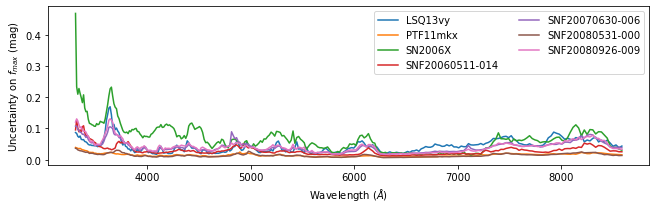

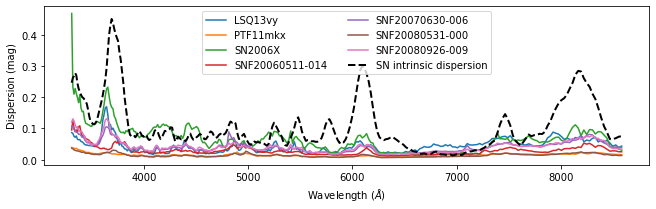

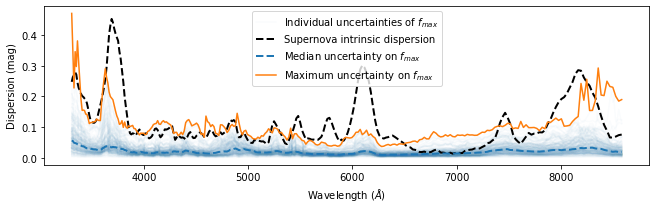

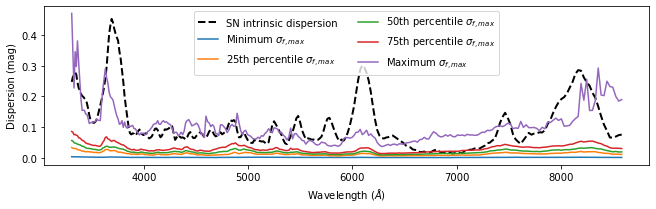

In [12]:
max_flux = a.differential_evolution_result['maximum_flux']
max_fluxerr = a.differential_evolution_result['maximum_fluxerr']

max_magerr = utils.frac_to_mag(max_fluxerr / max_flux)

rbtl_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])

def plot_uncertainties(show_rbtl=False):
    plt.figure(figsize=a.settings['spectrum_plot_figsize'])
    offset = 29
    
    # Make sure that we include the worst offender.
    max_loc = np.argmax(np.sum(max_magerr**2, axis=1))
    start = max_loc % offset
    
    for idx in range(start, len(a.targets), offset):
        plt.plot(a.wave, max_magerr[idx], label=a.targets[idx].name)
    plt.legend(ncol=2)
    
    plt.xlabel('Wavelength ($\AA$)')
    
    if show_rbtl:
        plt.plot(a.wave, rbtl_dispersion, label='SN intrinsic dispersion', c='k', lw=2, ls='--')
        plt.ylabel('Dispersion (mag)')
        filename = 'maximum_uncertainty_rbtl.pdf'
    else:
        plt.ylabel('Uncertainty on $f_{max}$ (mag)')
        filename = 'maximum_uncertainty_norbtl.pdf'
        
    plt.legend(ncol=2)
    a.savefig(filename)

plot_uncertainties(False)
plot_uncertainties(True)


plt.figure(figsize=a.settings['spectrum_plot_figsize'])
for idx in range(len(a.targets)):
    if idx == 0:
        label = 'Individual uncertainties of $f_{max}$'
    else:
        label = ''
    plt.plot(a.wave, max_magerr[idx], label=label, alpha=0.02, c='C0')
plt.plot(a.wave, rbtl_dispersion, label='Supernova intrinsic dispersion', lw=2, ls='--', c='k')
plt.plot(a.wave, np.median(max_magerr, axis=0), label='Median uncertainty on $f_{max}$', lw=2, ls='--', c='C0')
plt.plot(a.wave, np.max(max_magerr, axis=0), label='Maximum uncertainty on $f_{max}$', c='C1')
plt.legend()
plt.ylabel('Dispersion (mag)')
plt.xlabel('Wavelength ($\AA$)')
a.savefig('maximum_uncertainty_median.pdf')

plt.figure(figsize=a.settings['spectrum_plot_figsize'])
plt.plot(a.wave, rbtl_dispersion, label='SN intrinsic dispersion', lw=2, ls='--', c='k')
plt.plot(a.wave, np.min(max_magerr, axis=0), label='Minimum $\sigma_{f,max}$')
for percentile in (25, 50, 75):
    plt.plot(a.wave, np.percentile(max_magerr, percentile, axis=0), label='%dth percentile $\sigma_{f,max}$' % percentile)
plt.plot(a.wave, np.max(max_magerr, axis=0), label='Maximum $\sigma_{f,max}$')
plt.legend(ncol=2)
plt.ylabel('Dispersion (mag)')
plt.xlabel('Wavelength ($\AA$)')
a.savefig('maximum_uncertainty_percentile.pdf')

## Contribution to the total interpolation uncertainty from various sources

Interpolation of 0.0-1.5 days:
                 Raw: std=0.052, NMAD=0.039
               Phase: std=0.045, NMAD=0.034
          Phase + x1: std=0.045, NMAD=0.034
        Phase + gray: std=0.029, NMAD=0.014
   Phase + x1 + gray: std=0.029, NMAD=0.014

Interpolation of 1.5-2.5 days:
                 Raw: std=0.115, NMAD=0.087
               Phase: std=0.080, NMAD=0.066
          Phase + x1: std=0.080, NMAD=0.066
        Phase + gray: std=0.061, NMAD=0.042
   Phase + x1 + gray: std=0.061, NMAD=0.042

Interpolation of 2.5-5.5 days:
                 Raw: std=0.178, NMAD=0.126
               Phase: std=0.094, NMAD=0.075
          Phase + x1: std=0.094, NMAD=0.075
        Phase + gray: std=0.081, NMAD=0.055
   Phase + x1 + gray: std=0.081, NMAD=0.055

Interpolation of 5.5-10.5 days:
                 Raw: std=0.272, NMAD=0.209
               Phase: std=0.128, NMAD=0.098
          Phase + x1: std=0.128, NMAD=0.098
        Phase + gray: std=0.108, NMAD=0.076
   Phase + x1 + gray: std=0.108, NMA

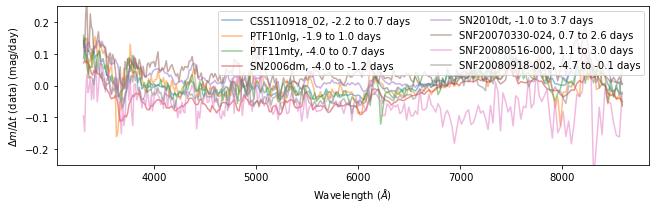

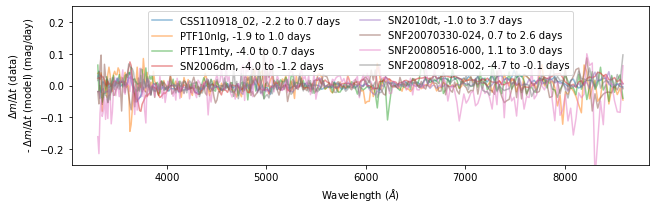

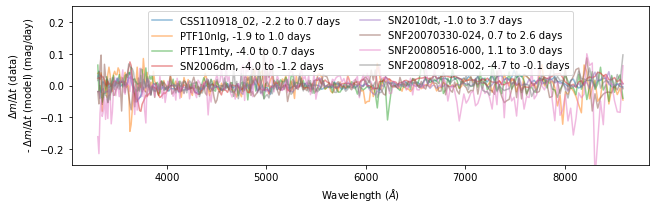

In [13]:
targets = []
diffs = []
phases_1 = []
phases_2 = []
x1s = []
gray_differences = []

gray_offsets = a.differential_evolution_result['gray_offsets']

center_specs = a.spectra[a.center_mask]
center_gray_offsets = gray_offsets[a.center_mask]
for target_idx in range(len(a.targets)):
    near_max_spec = center_specs[target_idx]
    
    target_mask = (a.target_map == target_idx) & (~a.center_mask)
    target_specs = a.spectra[target_mask]
    target_gray_offsets = gray_offsets[target_mask]
    
    for spec_idx, target_spec in enumerate(target_specs):
        phase_diff = target_spec.phase - near_max_spec.phase
        # if np.abs(phase_diff) < 1:
            # continue

        targets.append(a.targets[target_idx])
        diff = -2.5*np.log10(target_spec.flux / near_max_spec.flux)
        diffs.append(diff)
        phases_1.append(near_max_spec.phase)
        phases_2.append(target_spec.phase)
        x1s.append(a.salt_x1[target_idx])
        
        gray_differences.append(target_gray_offsets[spec_idx] - center_gray_offsets[target_idx])

targets = np.array(targets)
diffs = np.array(diffs)
phases_1 = np.array(phases_1)
phases_2 = np.array(phases_2)
x1s = np.array(x1s)
gray_differences = np.array(gray_differences)

phase_diffs = phases_2 - phases_1

def plot_diffs(diffs, model_subtracted=False):
    sel_mask = np.zeros(len(diffs), dtype=bool)
    sel_mask[4::50] = True
    sel_mask[np.abs(phase_diffs) < 1] = False
    
    plt.figure(figsize=a.settings['spectrum_plot_figsize'])
    
    for use_idx in np.where(sel_mask)[0]:
        target = targets[use_idx]
        phase_1 = phases_1[use_idx]
        phase_2 = phases_2[use_idx]
        
        if phase_1 > phase_2:
            phase_1, phase_2 = phase_2, phase_1
        
        label = '%s, %.1f to %.1f days' % (target, phase_1, phase_2)
        
        plt.plot(a.wave, diffs[use_idx] / phase_diffs[use_idx], alpha=0.5, label=label)
        
    plt.legend(ncol=2)

    plt.ylim(-0.25, 0.25)
    plt.xlabel('Wavelength ($\AA$)')
    if model_subtracted:
        plt.ylabel('$\Delta m / \Delta t$ (data)\n - $\Delta m / \Delta t$ (model) (mag/day)')
    else:
        plt.ylabel('$\Delta m / \Delta t$ (data) (mag/day)')

plot_diffs(diffs)
a.savefig('raw_phase_difference.pdf')

residuals_no_x1 = []
residuals_x1 = []
for diff, phase_1, phase_2, x1 in zip(diffs, phases_1, phases_2, x1s):
    model_no_x1 = evaluate_phase_difference(phase_2, 0) - evaluate_phase_difference(phase_1, 0)
    model_x1 = evaluate_phase_difference(phase_2, x1) - evaluate_phase_difference(phase_1, x1)
    residuals_no_x1.append(diff - model_no_x1)
    residuals_x1.append(diff - model_x1)
    
residuals_no_x1 = np.array(residuals_no_x1)
residuals_x1 = np.array(residuals_x1)

residuals_gray_no_x1 = residuals_no_x1 - gray_differences[:, None]
residuals_gray_x1 = residuals_x1 - gray_differences[:, None]

plot_diffs(residuals_gray_no_x1, True)
a.savefig('corr_phase_difference_no_x1.pdf')

plot_diffs(residuals_gray_x1, True)
a.savefig('corr_phase_difference_x1.pdf')

def print_interpolation_residuals(min_days, max_days):
    cut = (np.abs(phase_diffs) < max_days) & (np.abs(phase_diffs) > min_days)

    def do_print(label, vals, cut):
        cut_vals = vals[cut]
        print('%20s: std=%.3f, NMAD=%.3f' % (label, math.rms(cut_vals), math.nmad(cut_vals)))

    print("Interpolation of %.1f-%.1f days:" % (min_days, max_days))
    do_print('Raw', diffs, cut)    
    do_print('Phase', residuals_no_x1, cut)    
    do_print('Phase + x1', residuals_x1, cut)    
    do_print('Phase + gray', residuals_gray_no_x1, cut)    
    do_print('Phase + x1 + gray', residuals_gray_x1, cut)    
    print("")
    
print_interpolation_residuals(0., 1.5)
print_interpolation_residuals(1.5, 2.5)
print_interpolation_residuals(2.5, 5.5)
print_interpolation_residuals(5.5, 10.5)

## What fraction of the interpolation uncertainty is common?

<ipython-input-14-bd488f3d2726>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(phases, residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2), label='Fraction of dispersion remaining')
<ipython-input-14-bd488f3d2726>:26: RuntimeWarning: invalid value encountered in true_divide
  print("Median fraction of variance explained: %.3f" % (1 - np.nanmedian(residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2))))


Median fraction of variance explained: 0.846


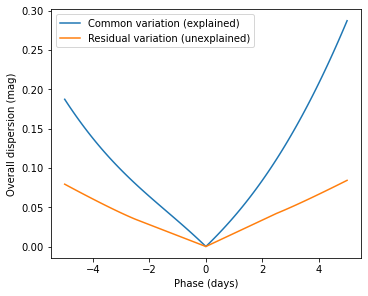

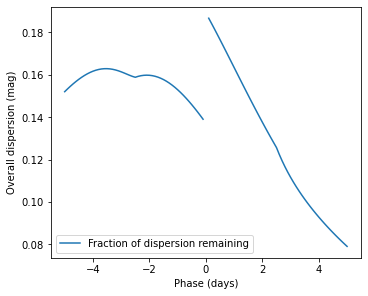

In [14]:
phases = np.linspace(-5, 5, 101)

common_dispersion = []
residual_dispersion = []

for phase in phases:
    common_dispersion.append(np.sqrt(np.mean(evaluate_phase_difference(phase)**2)))
    residual_dispersion.append(np.sqrt(np.mean(evaluate_phase_dispersion(phase)**2)))
    
common_dispersion = np.array(common_dispersion)
residual_dispersion = np.array(residual_dispersion)
    
plt.figure()
plt.plot(phases, common_dispersion, label='Common variation (explained)')
plt.plot(phases, residual_dispersion, label='Residual variation (unexplained)')
plt.legend()
plt.xlabel('Phase (days)')
plt.ylabel('Overall dispersion (mag)')

plt.figure()
plt.plot(phases, residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2), label='Fraction of dispersion remaining')
plt.legend()
plt.xlabel('Phase (days)')
plt.ylabel('Overall dispersion (mag)')

print("Median fraction of variance explained: %.3f" % (1 - np.nanmedian(residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2))))

## Test applying the model from a single spectrum to another.

Text(0.5, 1.0, 'Reference phase: 0.71 days')

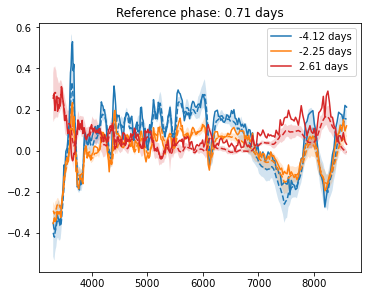

In [15]:
plt.figure()

idx = 0

target = a.targets[idx]
ref_spec = target.get_nearest_spectrum(0)
for spec_idx, spec in enumerate(target.get_spectra_in_range(-5, 5)):
    if spec == ref_spec:
        continue

    ref_mag = -2.5*np.log10(ref_spec.bin_by_velocity().flux)
    obs_mag = -2.5*np.log10(spec.bin_by_velocity().flux)
    model_diff = evaluate_phase_difference(spec.phase) - evaluate_phase_difference(ref_spec.phase)
    obs_diff = obs_mag - ref_mag
    uncertainty = np.sqrt(evaluate_phase_dispersion(spec.phase)**2 + evaluate_phase_dispersion(ref_spec.phase)**2)

    plt.plot(a.wave, obs_diff, c=f'C{spec_idx}', label=f'{spec.phase:.2f} days')
    plt.plot(a.wave, model_diff, c=f'C{spec_idx}', ls='--')
    plt.fill_between(a.wave, model_diff - uncertainty, model_diff + uncertainty, fc=f'C{spec_idx}', alpha=0.2)
    
plt.legend()

plt.title(f'Reference phase: {ref_spec.phase:.2f} days')

## Look at the pulls

Text(0.5, 0, 'Pulls')

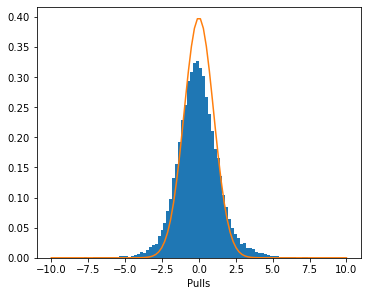

In [16]:
plt.figure()

all_pulls = []

for idx in range(len(a.targets)):
    target = a.targets[idx]
    ref_spec = target.get_nearest_spectrum(0)
    for spec_idx, spec in enumerate(target.get_spectra_in_range(-5, 5)):
        if spec == ref_spec:
            continue

        if np.abs(ref_spec.phase) > 1:
            continue

        if np.abs(spec.phase) < 3:
            continue
            
        bin_ref_spec = ref_spec.bin_by_velocity()
        bin_spec = spec.bin_by_velocity()

        ref_mag = -2.5*np.log10(bin_ref_spec.flux)
        obs_mag = -2.5*np.log10(bin_spec.flux)
        model_diff = evaluate_phase_difference(spec.phase) - evaluate_phase_difference(ref_spec.phase)
        obs_diff = obs_mag - ref_mag
        
        # Note: uncertainties are correlated so this isn't totally correct (and will underestimate them)
        # It is reasonably close though.
        uncertainty = np.sqrt(evaluate_phase_dispersion(spec.phase)**2 + evaluate_phase_dispersion(ref_spec.phase)**2 + bin_spec.fluxvar + bin_ref_spec.fluxvar)
        
        dd = obs_diff - model_diff
        zp = np.sum(1 / uncertainty**2 * dd) / np.sum(1 / uncertainty**2)
        dd = dd - zp
        
        pulls = (dd) / uncertainty
        
        # plt.plot(a.wave, (obs_diff - model_diff) / uncertainty, lw=1)
        all_pulls.append(pulls)

plt.hist(np.array(all_pulls).flat, 100, (-10, 10), density=True)
x = np.linspace(-10, 10, 100)
plt.plot(x, 1 / np.sqrt(2 * np.pi * 1.**2) * np.exp(-x**2 / 2 / 1.**2))
# plt.plot(x, 1 / np.sqrt(2 * np.pi * 1.2**2) * np.exp(-x**2 / 2 / 1.2**2))
plt.xlabel("Pulls")

# Dump of the model parameters

In [17]:
def to_str(fmt, x):
    return [fmt % i for i in x]
    

data_table = Table({
    'Wavelength': to_str('%d', a.wave),
    'Time evolution c1': to_str('%.3f', a.differential_evolution_result['phase_slope']),
    'Time evolution c2': to_str('%.5f', a.differential_evolution_result['phase_quadratic']),
    'Model uncertainties -5.0 days': to_str('%.3f', evaluate_phase_dispersion(-5)),
    'Model uncertainties -2.5 days': to_str('%.3f', evaluate_phase_dispersion(-2.5)),
    'Model uncertainties +2.5 days': to_str('%.3f', evaluate_phase_dispersion(2.5)),
    'Model uncertainties +5.0 days': to_str('%.3f', evaluate_phase_dispersion(5.)),
    'RBTL intrinsic dispersion': to_str('%.3f', utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])),
})

def dump_data(f, count=None):
    if count is not None:
        offset = len(data_table) // count
        ref = offset // 2
    else:
        offset = None
        ref = None
        
    for row in data_table[ref::offset]:
        print(' & '.join(row) + ' \\\\', file=f)

with a.latex_open('differential_time_evolution_parameters.tex') as f:
    dump_data(f)

with a.latex_open('differential_time_evolution_parameters_short.tex') as f:
    dump_data(f, 10)